# Pre-Processing and Training Data

## Remember

The purpose of this project is to build a predictive model for Economic index based on school demographics in NYC. This model will be used to provide guidance for NYC's education system plan and aim to decrease economic indexes by borough.








## The next step is to 

1. Load the data


2. Split the data 


3. Scale and ecode data if necessary


4. initiate the model 


5. Create the Pipeline


6. fit the pipeline


We are going to use PySpark Mlib

to train and prprocess our model.

We are also going to import the libraries we want to use first

In [111]:
import pyspark
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import category_encoders as e
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import keras
import keras.utils
from keras import utils as np_utils
import tensorflow as tf
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

# Initiate Spark

In [112]:
nyc_data_model = pd.read_csv('../data/nyc_data_modeling.csv')

In [113]:
spark = SparkSession.builder.master("local[1]") \
                    .appName('SparkByExamples.com') \
                    .config("spark.driver.bindAddress", "127.0.0.1") \
                    .getOrCreate()

22/12/01 16:46:50 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [114]:
sc = spark.sparkContext
sc

<SparkContext master=local[1] appName=SparkByExamples.com>

In [115]:
#sc.stop()

In [116]:
print("Spark Version: {}".format(sc.version))

Spark Version: 3.3.1


In [117]:
print("Spark Version: {}".format(sc.pythonVer))

Spark Version: 3.9


In [118]:
print("Spark Version: {}".format(sc.master))

Spark Version: local[1]


# Load data

In [119]:
PATH = '../data/nyc_data_modeling.csv'

In [120]:
# Pandas

nyc_pandas = pd.read_csv(PATH).iloc[:,1:]

In [121]:
#Spark
nyc_spark = spark.read.csv(PATH, header=True, inferSchema=True)

PySpark makes no such inferences. By default, PySpark will treat the header as the first row and all columns as string variables. To prevent PySpark from making any false assumptions, the user must assign values to the header and inferSchema parameters.

In [122]:
nyc_pandas.head()

,Year,# Male,# Asian,# Black,# Hispanic,# Multi-Racial,# Native American,# White,# Missing Race/Ethnicity Data,# Students with Disabilities,# English Language Learners,Economic Need Index,Borough,District Number,Economic Support,Pre School,Elementary School,Middle School,High School
0,2016-17,95,14,51,105,3,1,4,0,51,12,88.2,Manhattan,1,Need Support,45,133,0,0
1,2017-18,91,20,52,110,1,1,6,0,49,8,89.0,Manhattan,1,Need Support,45,145,0,0
2,2018-19,89,24,48,95,0,1,6,0,39,8,88.8,Manhattan,1,Need Support,33,141,0,0
3,2019-20,96,27,56,96,0,2,9,0,46,17,86.7,Manhattan,1,Need Support,43,147,0,0
4,2020-21,92,26,53,102,1,0,11,0,43,21,85.6,Manhattan,1,Need Support,46,147,0,0


Since PySpark implements lazy execution, it requires a trigger that derives the results of any operation. In this case, the show function acts as the trigger, letting the user view the loaded dataset.

In [123]:
nyc_pandas.describe()

,# Male,# Asian,# Black,# Hispanic,# Multi-Racial,# Native American,# White,# Missing Race/Ethnicity Data,# Students with Disabilities,# English Language Learners,Economic Need Index,District Number,Pre School,Elementary School,Middle School,High School
count,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000,9169.000000
mean,301.697241,95.272113,149.827898,239.106009,6.453594,6.534300,86.237321,2.524376,122.522303,80.493620,73.083172,27.062820,60.735304,220.988439,127.866834,176.365034
std,252.467601,217.404728,166.121062,223.101691,12.272638,14.409499,180.892501,8.999338,97.894632,106.569319,20.205806,26.072237,75.858914,260.187174,266.269458,467.812553
min,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,162.000000,5.000000,41.000000,90.000000,1.000000,1.000000,6.000000,0.000000,67.000000,18.000000,63.300000,10.000000,0.000000,0.000000,0.000000,0.000000
50%,245.000000,17.000000,102.000000,181.000000,2.000000,3.000000,15.000000,0.000000,99.000000,44.000000,79.200000,19.000000,46.000000,153.000000,0.000000,0.000000
75%,359.000000,81.000000,192.000000,313.000000,7.000000,7.000000,78.000000,1.000000,146.000000,100.000000,88.600000,29.000000,104.000000,389.000000,187.000000,248.000000
max,3635.000000,3671.000000,1493.000000,2056.000000,181.000000,355.000000,3104.000000,234.000000,925.000000,1168.000000,95.000000,84.000000,1328.000000,1688.000000,2265.000000,6040.000000


In [124]:
nyc_spark.describe().show()

22/12/01 16:46:52 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Year, # Male, # Asian, # Black, # Hispanic, # Multi-Racial, # Native American, # White, # Missing Race/Ethnicity Data, # Students with Disabilities, # English Language Learners, Economic Need Index, Borough, District Number, Economic Support, Pre School, Elementary School, Middle School, High School
 Schema: _c0, Year, # Male, # Asian, # Black, # Hispanic, # Multi-Racial, # Native American, # White, # Missing Race/Ethnicity Data, # Students with Disabilities, # English Language Learners, Economic Need Index, Borough, District Number, Economic Support, Pre School, Elementary School, Middle School, High School
Expected: _c0 but found: 
CSV file: file:///Users/taehyun/Dropbox/Springboard/NYC_Capstone_project/NewYorkCity_Education/data/nyc_data_modeling.csv


+-------+-----------------+-------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------------------+----------------------------+---------------------------+-------------------+-------------+------------------+----------------+-----------------+------------------+------------------+------------------+
|summary|              _c0|   Year|            # Male|           # Asian|           # Black|        # Hispanic|    # Multi-Racial| # Native American|          # White|# Missing Race/Ethnicity Data|# Students with Disabilities|# English Language Learners|Economic Need Index|      Borough|   District Number|Economic Support|       Pre School| Elementary School|     Middle School|       High School|
+-------+-----------------+-------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------------------+---

There is a random column in spark dataframe. Let's get rid of it.

In [125]:
nyc_spark = nyc_spark.drop('_c0')

We can also get rid of the categorical column economic support since we can directly predit the economic need index and deteremine which category it fits. 

In [126]:
nyc_spark = nyc_spark.drop('Economic Support')

In [127]:
print(nyc_spark.printSchema())

root
 |-- Year: string (nullable = true)
 |-- # Male: integer (nullable = true)
 |-- # Asian: integer (nullable = true)
 |-- # Black: integer (nullable = true)
 |-- # Hispanic: integer (nullable = true)
 |-- # Multi-Racial: integer (nullable = true)
 |-- # Native American: integer (nullable = true)
 |-- # White: integer (nullable = true)
 |-- # Missing Race/Ethnicity Data: integer (nullable = true)
 |-- # Students with Disabilities: integer (nullable = true)
 |-- # English Language Learners: integer (nullable = true)
 |-- Economic Need Index: double (nullable = true)
 |-- Borough: string (nullable = true)
 |-- District Number: integer (nullable = true)
 |-- Pre School: integer (nullable = true)
 |-- Elementary School: integer (nullable = true)
 |-- Middle School: integer (nullable = true)
 |-- High School: integer (nullable = true)

None


In [128]:
columns_to_drop = ['Economic Support']
nyc_spark = nyc_spark.drop(*columns_to_drop)
nyc_pandas = nyc_pandas.drop(['Economic Support'], axis=1)

### String Indexer -> OHEncode

In [129]:
indexer = StringIndexer(inputCols = ['Borough','District Number','Year'], outputCols = ['Borough_label','District Number_label','Year_label'])
nyc_spark_index = indexer.fit(nyc_spark).transform(nyc_spark)

In [130]:
ohe_encoder = OneHotEncoder(inputCols = ['Borough_label','District Number_label','Year_label'], outputCols = ['Borough_ohe','District Number_ohe','Year_ohe'], dropLast = True)
ohe_encoder_index = ohe_encoder.fit(nyc_spark_index).transform(nyc_spark_index)

In [131]:
ohe_encoder_index.show()

+-------+------+-------+-------+----------+--------------+-----------------+-------+-----------------------------+----------------------------+---------------------------+-------------------+---------+---------------+----------+-----------------+-------------+-----------+-------------+---------------------+----------+-------------+-------------------+-------------+
|   Year|# Male|# Asian|# Black|# Hispanic|# Multi-Racial|# Native American|# White|# Missing Race/Ethnicity Data|# Students with Disabilities|# English Language Learners|Economic Need Index|  Borough|District Number|Pre School|Elementary School|Middle School|High School|Borough_label|District Number_label|Year_label|  Borough_ohe|District Number_ohe|     Year_ohe|
+-------+------+-------+-------+----------+--------------+-----------------+-------+-----------------------------+----------------------------+---------------------------+-------------------+---------+---------------+----------+-----------------+-------------+----

### Scale the Data

In [132]:
vec_assembler = VectorAssembler(inputCols = ['# Male', '# Asian', '# Black', '# Hispanic', '# Multi-Racial',
       '# Native American', '# White', '# Missing Race/Ethnicity Data',
       '# Students with Disabilities', '# English Language Learners', 'Pre School',
       'Elementary School', 'Middle School', 'High School','Borough_ohe','District Number_ohe','Year_ohe'], outputCol = 'feature')

vec_assemb = vec_assembler.transform(ohe_encoder_index)
vec_assemb

DataFrame[Year: string, # Male: int, # Asian: int, # Black: int, # Hispanic: int, # Multi-Racial: int, # Native American: int, # White: int, # Missing Race/Ethnicity Data: int, # Students with Disabilities: int, # English Language Learners: int, Economic Need Index: double, Borough: string, District Number: int, Pre School: int, Elementary School: int, Middle School: int, High School: int, Borough_label: double, District Number_label: double, Year_label: double, Borough_ohe: vector, District Number_ohe: vector, Year_ohe: vector, feature: vector]

In [133]:
from pyspark.ml.feature import StandardScaler
scaler =  StandardScaler().setInputCol('feature').setOutputCol("feature_scaled")
vec_scaled_train = scaler.fit(vec_assemb).transform(vec_assemb)

## Split the data

In [134]:
(train_df, test_df) = vec_scaled_train.randomSplit([0.8, 0.2])

## Model 1. Linear Regression

The model I chose is linear Regression and I chose it since it is a classic regression model with linear algorithm. Simply all the calculation of the functions add up to the dependent variable.

I am going to use the following parameters and tune it.

1. elasticNetParam = 1.0
by setting it equal to 1.0, it means that it's lasso regression which is L1.

I chose L1 penalization over L2 because I have a lot of outliers in my data set. Since L1 takes the manhattan distance meaning it is penalizing the !absolute value! of the weights so it is more robust to outliers.

The down side of L1 would be the case when we have highly correlated features, the L1 norm would select only 1 of the features from the group of correlated features in an arbitrary nature so lasso regression also acts as a feature selector.

0.5 would be the mix of L1 and L2.

In general, Lasso regression (Linear Regression with L1 regularization) would produce a model that is highly interpretable, and only uses a subset of input features, thus reducing the complexity of the model.

2. MaxItr = 100,150,200,250
This has no reason. The higher the iteration, prone to overfit. 

3. regParam
This is unknown. We have to try multiple values


In [135]:
metric_list = []

In [136]:
linear_regressor = LinearRegression(featuresCol = 'feature_scaled', labelCol = 'Economic Need Index')

## Tune the model now

In [137]:
# alpha = 0 - penalty L2
paramGrid = (ParamGridBuilder()
               .addGrid(linear_regressor.maxIter, [100,150,200,250])
               .addGrid(linear_regressor.elasticNetParam, [0.1,0.5,1.0])
               .addGrid(linear_regressor.regParam, [0.3,0.6,0.9])
               .build())

In [138]:
evaluator = RegressionEvaluator(labelCol="Economic Need Index",
                                predictionCol="prediction",
                                metricName="mae")

regressorcv = CrossValidator(estimator = linear_regressor,
                            estimatorParamMaps = paramGrid,
                            evaluator = evaluator,
                            numFolds = 5)

linear_regression_cv = regressorcv.fit(train_df)

## Evaluate¶

In [139]:
lr_regressor_predictions = linear_regression_cv.transform(test_df)
print('MAE:', evaluator.evaluate(lr_regressor_predictions))
metric_list.append(evaluator.evaluate(lr_regressor_predictions))

MAE: 7.739989309477424


### Extra Notes about preprocessing

Sparks one hot encoder: have to convert String to index and then convert again to one hot encode.

sklearns one hot encoder: converts directly to index from String

so basically, the above solution is splitting the data after encoding and scaling and the bottom solution is I split the data first and encoded. According to the evaluation metrics, the score doesn't have a difference at all. Therefore, I prefer using the top method which contains less code. 

Steps:
Encode -> Scale(Normalize) -> Split -> Model -> Evaluate

### Encoding

In [140]:
#from pyspark.ml.feature import OneHotEncoder
#from pyspark.ml.feature import StringIndexer
#from pyspark.ml.feature import VectorAssembler
#from pyspark.ml.feature import StandardScaler

#indexer = StringIndexer(inputCols = ['Borough','District Number','Year'], outputCols = ['Borough_label','District Number_label','Year_label'])
#label_df_train = indexer.fit(train_df).transform(train_df)
#label_df_test = indexer.fit(test_df).transform(test_df)

In [141]:
#ohe_encoder = OneHotEncoder(inputCols = ['Borough_label','District Number_label','Year_label'], outputCols = ['Borough_ohe','District Number_ohe','Year_ohe'], dropLast = True)
#encoding_df_train = ohe_encoder.fit(label_df_train).transform(label_df_train)
#encoding_df_test = ohe_encoder.fit(label_df_test).transform(label_df_test)

### Scaling

In spark, when we scale, we have to perform vectorAssembler to perform Feature Vectorization meaning all the columns should be vectorized. 

In [142]:
#vec_assembler = VectorAssembler(inputCols = ['# Male', '# Asian', '# Black', '# Hispanic', '# Multi-Racial',
       #'# Native American', '# White', '# Missing Race/Ethnicity Data',
       #'# Students with Disabilities', '# English Language Learners', 'Pre School',
       #'Elementary School', 'Middle School', 'High School','Borough_ohe','District Number_ohe','Year_ohe'], outputCol = 'feature')

#vec_assemb_train = vec_assembler.transform(encoding_df_train)
#vec_assemb_test = vec_assembler.transform(encoding_df_test)

In [143]:
#scaler = StandardScaler(inputCol='feature', outputCol='feature_scaled', withMean=True, withStd=True)
#vec_scaled_train = scaler.fit(vec_assemb).transform(vec_assemb_train)
#vec_scaled_test = scaler.fit(vec_assemb).transform(vec_assemb_test)

### Create Model

In [144]:
#from pyspark.ml.regression import LinearRegression

#regressor = LinearRegression(featuresCol = 'feature_scaled', labelCol = 'Economic Need Index')

In [145]:
#linear_model = regressor.fit(vec_scaled_train)

In [146]:
#print("Coefficients: " + str(linear_model.coefficients))
#print("\nIntercept: " + str(linear_model.intercept))
#trainSummary = linear_model.summary
#print("RMSE: %f" % trainSummary.rootMeanSquaredError)
#print("\nr2: %f" % trainSummary.r2)

In [147]:
#pred = linear_model.evaluate(vec_scaled_test)
#pred.predictions.toPandas().iloc[:,10:].head()

In [148]:
#print('‘MAE for test set:’', pred.meanAbsoluteError)
#print('MSE for test set:', pred.meanSquaredError)
#print('RMSE for test set:', pred.rootMeanSquaredError)
#print('R2-Score for test set:', pred.r2)

### Model 2: Decision tree Regression

I chose Decision tree Regression because it is

In [149]:
regressor = DecisionTreeRegressor(featuresCol = 'feature_scaled', labelCol = 'Economic Need Index')

## Binning feature values

Increasing maxBins allows the algorithm to consider more split candidates and make fine-grained split decisions. However, it also increases computation and communication.

Note that the maxBins parameter must be at least the maximum number of categories M for any categorical feature.

### Max depth

Increasing the depth leads to overfitting since it increases its complexity. 

## Tuning the model

In [150]:
paramGrid = (ParamGridBuilder()
               .addGrid(regressor.maxDepth, [2,5,10,2,30])
               .addGrid(regressor.maxBins, [10,20,40,80,100])
               .build())

### Evaluation

In [151]:
evaluator = RegressionEvaluator(labelCol="Economic Need Index",
                                predictionCol="prediction",
                                metricName="mae")

regressorcv = CrossValidator(estimator = regressor,
                            estimatorParamMaps = paramGrid,
                            evaluator = evaluator,
                            numFolds = 5)


In [152]:
tree_regressor_model = regressorcv.fit(train_df)

22/12/01 16:48:34 WARN DAGScheduler: Broadcasting large task binary with size 1126.5 KiB
22/12/01 16:48:35 WARN DAGScheduler: Broadcasting large task binary with size 1250.7 KiB
22/12/01 16:48:35 WARN DAGScheduler: Broadcasting large task binary with size 1356.6 KiB
22/12/01 16:48:35 WARN DAGScheduler: Broadcasting large task binary with size 1450.3 KiB
22/12/01 16:48:36 WARN DAGScheduler: Broadcasting large task binary with size 1528.7 KiB
22/12/01 16:48:36 WARN DAGScheduler: Broadcasting large task binary with size 1591.5 KiB
22/12/01 16:48:36 WARN DAGScheduler: Broadcasting large task binary with size 1639.5 KiB
22/12/01 16:48:36 WARN DAGScheduler: Broadcasting large task binary with size 1672.8 KiB
22/12/01 16:48:36 WARN DAGScheduler: Broadcasting large task binary with size 1694.1 KiB
22/12/01 16:48:37 WARN DAGScheduler: Broadcasting large task binary with size 1707.3 KiB
22/12/01 16:48:37 WARN DAGScheduler: Broadcasting large task binary with size 1714.3 KiB
22/12/01 16:48:37 WAR

22/12/01 16:48:51 WARN DAGScheduler: Broadcasting large task binary with size 1401.3 KiB
22/12/01 16:48:52 WARN DAGScheduler: Broadcasting large task binary with size 1475.8 KiB
22/12/01 16:48:52 WARN DAGScheduler: Broadcasting large task binary with size 1538.9 KiB
22/12/01 16:48:53 WARN DAGScheduler: Broadcasting large task binary with size 1593.8 KiB
22/12/01 16:48:53 WARN DAGScheduler: Broadcasting large task binary with size 1635.7 KiB
22/12/01 16:48:54 WARN DAGScheduler: Broadcasting large task binary with size 1671.1 KiB
22/12/01 16:48:54 WARN DAGScheduler: Broadcasting large task binary with size 1693.6 KiB
22/12/01 16:48:54 WARN DAGScheduler: Broadcasting large task binary with size 1707.0 KiB
22/12/01 16:48:55 WARN DAGScheduler: Broadcasting large task binary with size 1715.7 KiB
22/12/01 16:48:55 WARN DAGScheduler: Broadcasting large task binary with size 1721.0 KiB
22/12/01 16:48:55 WARN DAGScheduler: Broadcasting large task binary with size 1725.1 KiB
22/12/01 16:48:55 WAR

22/12/01 16:49:01 WARN DAGScheduler: Broadcasting large task binary with size 1043.1 KiB


22/12/01 16:49:02 WARN DAGScheduler: Broadcasting large task binary with size 1169.0 KiB
22/12/01 16:49:03 WARN DAGScheduler: Broadcasting large task binary with size 1277.5 KiB


22/12/01 16:49:04 WARN DAGScheduler: Broadcasting large task binary with size 1375.1 KiB
22/12/01 16:49:04 WARN DAGScheduler: Broadcasting large task binary with size 1458.1 KiB
22/12/01 16:49:05 WARN DAGScheduler: Broadcasting large task binary with size 1524.8 KiB
22/12/01 16:49:05 WARN DAGScheduler: Broadcasting large task binary with size 1575.4 KiB
22/12/01 16:49:06 WARN DAGScheduler: Broadcasting large task binary with size 1613.0 KiB
22/12/01 16:49:06 WARN DAGScheduler: Broadcasting large task binary with size 1646.1 KiB
22/12/01 16:49:07 WARN DAGScheduler: Broadcasting large task binary with size 1674.1 KiB
22/12/01 16:49:07 WARN DAGScheduler: Broadcasting large task binary with size 1694.5 KiB
22/12/01 16:49:07 WARN DAGScheduler: Broadcasting large task binary with size 1713.1 KiB
22/12/01 16:49:08 WARN DAGScheduler: Broadcasting large task binary with size 1724.9 KiB
22/12/01 16:49:08 WARN DAGScheduler: Broadcasting large task binary with size 1732.8 KiB
22/12/01 16:49:08 WAR

22/12/01 16:49:17 WARN DAGScheduler: Broadcasting large task binary with size 1013.4 KiB


22/12/01 16:49:18 WARN DAGScheduler: Broadcasting large task binary with size 1147.8 KiB


22/12/01 16:49:19 WARN DAGScheduler: Broadcasting large task binary with size 1267.6 KiB


22/12/01 16:49:20 WARN DAGScheduler: Broadcasting large task binary with size 1365.9 KiB
22/12/01 16:49:21 WARN DAGScheduler: Broadcasting large task binary with size 1444.4 KiB
22/12/01 16:49:22 WARN DAGScheduler: Broadcasting large task binary with size 1503.5 KiB
22/12/01 16:49:22 WARN DAGScheduler: Broadcasting large task binary with size 1555.4 KiB
22/12/01 16:49:23 WARN DAGScheduler: Broadcasting large task binary with size 1596.9 KiB
22/12/01 16:49:23 WARN DAGScheduler: Broadcasting large task binary with size 1635.7 KiB
22/12/01 16:49:24 WARN DAGScheduler: Broadcasting large task binary with size 1666.5 KiB
22/12/01 16:49:24 WARN DAGScheduler: Broadcasting large task binary with size 1690.4 KiB
22/12/01 16:49:24 WARN DAGScheduler: Broadcasting large task binary with size 1708.1 KiB
22/12/01 16:49:25 WARN DAGScheduler: Broadcasting large task binary with size 1721.6 KiB
22/12/01 16:49:25 WARN DAGScheduler: Broadcasting large task binary with size 1731.4 KiB
22/12/01 16:49:25 WAR

22/12/01 16:50:17 WARN DAGScheduler: Broadcasting large task binary with size 1033.1 KiB


22/12/01 16:50:18 WARN DAGScheduler: Broadcasting large task binary with size 1158.9 KiB
22/12/01 16:50:19 WARN DAGScheduler: Broadcasting large task binary with size 1268.0 KiB
22/12/01 16:50:20 WARN DAGScheduler: Broadcasting large task binary with size 1362.2 KiB
22/12/01 16:50:20 WARN DAGScheduler: Broadcasting large task binary with size 1438.6 KiB
22/12/01 16:50:21 WARN DAGScheduler: Broadcasting large task binary with size 1499.0 KiB
22/12/01 16:50:21 WARN DAGScheduler: Broadcasting large task binary with size 1551.6 KiB
22/12/01 16:50:21 WARN DAGScheduler: Broadcasting large task binary with size 1595.1 KiB
22/12/01 16:50:22 WARN DAGScheduler: Broadcasting large task binary with size 1630.6 KiB
22/12/01 16:50:22 WARN DAGScheduler: Broadcasting large task binary with size 1660.6 KiB
22/12/01 16:50:23 WARN DAGScheduler: Broadcasting large task binary with size 1685.1 KiB
22/12/01 16:50:23 WARN DAGScheduler: Broadcasting large task binary with size 1702.7 KiB
22/12/01 16:50:23 WAR

22/12/01 16:50:31 WARN DAGScheduler: Broadcasting large task binary with size 1098.7 KiB


22/12/01 16:50:32 WARN DAGScheduler: Broadcasting large task binary with size 1219.5 KiB
22/12/01 16:50:32 WARN DAGScheduler: Broadcasting large task binary with size 1322.5 KiB
22/12/01 16:50:33 WARN DAGScheduler: Broadcasting large task binary with size 1408.3 KiB
22/12/01 16:50:34 WARN DAGScheduler: Broadcasting large task binary with size 1475.4 KiB
22/12/01 16:50:34 WARN DAGScheduler: Broadcasting large task binary with size 1531.5 KiB
22/12/01 16:50:35 WARN DAGScheduler: Broadcasting large task binary with size 1582.1 KiB
22/12/01 16:50:35 WARN DAGScheduler: Broadcasting large task binary with size 1623.0 KiB
22/12/01 16:50:36 WARN DAGScheduler: Broadcasting large task binary with size 1654.8 KiB
22/12/01 16:50:36 WARN DAGScheduler: Broadcasting large task binary with size 1676.6 KiB
22/12/01 16:50:36 WARN DAGScheduler: Broadcasting large task binary with size 1694.8 KiB
22/12/01 16:50:37 WARN DAGScheduler: Broadcasting large task binary with size 1709.5 KiB
22/12/01 16:50:37 WAR

22/12/01 16:51:25 WARN DAGScheduler: Broadcasting large task binary with size 1057.3 KiB
22/12/01 16:51:26 WARN DAGScheduler: Broadcasting large task binary with size 1188.0 KiB
22/12/01 16:51:27 WARN DAGScheduler: Broadcasting large task binary with size 1298.5 KiB
22/12/01 16:51:27 WARN DAGScheduler: Broadcasting large task binary with size 1388.2 KiB
22/12/01 16:51:28 WARN DAGScheduler: Broadcasting large task binary with size 1464.3 KiB
22/12/01 16:51:28 WARN DAGScheduler: Broadcasting large task binary with size 1527.9 KiB
22/12/01 16:51:29 WARN DAGScheduler: Broadcasting large task binary with size 1580.7 KiB
22/12/01 16:51:29 WARN DAGScheduler: Broadcasting large task binary with size 1624.3 KiB
22/12/01 16:51:30 WARN DAGScheduler: Broadcasting large task binary with size 1658.2 KiB
22/12/01 16:51:30 WARN DAGScheduler: Broadcasting large task binary with size 1685.5 KiB
22/12/01 16:51:30 WARN DAGScheduler: Broadcasting large task binary with size 1706.8 KiB
22/12/01 16:51:31 WAR

22/12/01 16:51:38 WARN DAGScheduler: Broadcasting large task binary with size 1037.4 KiB


22/12/01 16:51:39 WARN DAGScheduler: Broadcasting large task binary with size 1162.7 KiB


22/12/01 16:51:40 WARN DAGScheduler: Broadcasting large task binary with size 1272.4 KiB
22/12/01 16:51:40 WARN DAGScheduler: Broadcasting large task binary with size 1366.3 KiB
22/12/01 16:51:41 WARN DAGScheduler: Broadcasting large task binary with size 1450.1 KiB
22/12/01 16:51:41 WARN DAGScheduler: Broadcasting large task binary with size 1518.6 KiB
22/12/01 16:51:42 WARN DAGScheduler: Broadcasting large task binary with size 1575.1 KiB
22/12/01 16:51:42 WARN DAGScheduler: Broadcasting large task binary with size 1621.3 KiB
22/12/01 16:51:43 WARN DAGScheduler: Broadcasting large task binary with size 1655.9 KiB
22/12/01 16:51:43 WARN DAGScheduler: Broadcasting large task binary with size 1682.9 KiB
22/12/01 16:51:44 WARN DAGScheduler: Broadcasting large task binary with size 1703.9 KiB
22/12/01 16:51:44 WARN DAGScheduler: Broadcasting large task binary with size 1716.7 KiB
22/12/01 16:51:44 WARN DAGScheduler: Broadcasting large task binary with size 1723.6 KiB
22/12/01 16:51:44 WAR

22/12/01 16:52:22 WARN DAGScheduler: Broadcasting large task binary with size 1252.2 KiB
22/12/01 16:52:22 WARN DAGScheduler: Broadcasting large task binary with size 1344.6 KiB
22/12/01 16:52:23 WARN DAGScheduler: Broadcasting large task binary with size 1426.1 KiB
22/12/01 16:52:23 WARN DAGScheduler: Broadcasting large task binary with size 1495.0 KiB
22/12/01 16:52:23 WARN DAGScheduler: Broadcasting large task binary with size 1551.2 KiB
22/12/01 16:52:24 WARN DAGScheduler: Broadcasting large task binary with size 1603.6 KiB
22/12/01 16:52:24 WARN DAGScheduler: Broadcasting large task binary with size 1644.4 KiB
22/12/01 16:52:25 WARN DAGScheduler: Broadcasting large task binary with size 1672.4 KiB
22/12/01 16:52:25 WARN DAGScheduler: Broadcasting large task binary with size 1694.1 KiB
22/12/01 16:52:25 WARN DAGScheduler: Broadcasting large task binary with size 1708.5 KiB
22/12/01 16:52:25 WARN DAGScheduler: Broadcasting large task binary with size 1716.3 KiB
22/12/01 16:52:26 WAR

22/12/01 16:52:44 WARN DAGScheduler: Broadcasting large task binary with size 1033.7 KiB


22/12/01 16:52:46 WARN DAGScheduler: Broadcasting large task binary with size 1156.7 KiB


22/12/01 16:52:47 WARN DAGScheduler: Broadcasting large task binary with size 1262.1 KiB


22/12/01 16:52:48 WARN DAGScheduler: Broadcasting large task binary with size 1354.3 KiB
22/12/01 16:52:49 WARN DAGScheduler: Broadcasting large task binary with size 1431.7 KiB
22/12/01 16:52:49 WARN DAGScheduler: Broadcasting large task binary with size 1500.8 KiB
22/12/01 16:52:50 WARN DAGScheduler: Broadcasting large task binary with size 1558.7 KiB
22/12/01 16:52:50 WARN DAGScheduler: Broadcasting large task binary with size 1612.0 KiB
22/12/01 16:52:51 WARN DAGScheduler: Broadcasting large task binary with size 1657.0 KiB
22/12/01 16:52:51 WARN DAGScheduler: Broadcasting large task binary with size 1691.2 KiB
22/12/01 16:52:52 WARN DAGScheduler: Broadcasting large task binary with size 1714.8 KiB
22/12/01 16:52:52 WARN DAGScheduler: Broadcasting large task binary with size 1729.5 KiB
22/12/01 16:52:52 WARN DAGScheduler: Broadcasting large task binary with size 1738.2 KiB
22/12/01 16:52:53 WARN DAGScheduler: Broadcasting large task binary with size 1741.8 KiB
22/12/01 16:52:53 WAR

22/12/01 16:53:01 WARN DAGScheduler: Broadcasting large task binary with size 1113.0 KiB


22/12/01 16:53:03 WARN DAGScheduler: Broadcasting large task binary with size 1222.2 KiB


22/12/01 16:53:04 WARN DAGScheduler: Broadcasting large task binary with size 1318.0 KiB


22/12/01 16:53:05 WARN DAGScheduler: Broadcasting large task binary with size 1403.1 KiB
22/12/01 16:53:06 WARN DAGScheduler: Broadcasting large task binary with size 1476.7 KiB
22/12/01 16:53:06 WARN DAGScheduler: Broadcasting large task binary with size 1541.0 KiB
22/12/01 16:53:07 WARN DAGScheduler: Broadcasting large task binary with size 1592.7 KiB
22/12/01 16:53:07 WARN DAGScheduler: Broadcasting large task binary with size 1635.3 KiB
22/12/01 16:53:08 WARN DAGScheduler: Broadcasting large task binary with size 1670.5 KiB
22/12/01 16:53:08 WARN DAGScheduler: Broadcasting large task binary with size 1696.1 KiB
22/12/01 16:53:08 WARN DAGScheduler: Broadcasting large task binary with size 1714.3 KiB
22/12/01 16:53:09 WARN DAGScheduler: Broadcasting large task binary with size 1726.7 KiB
22/12/01 16:53:09 WARN DAGScheduler: Broadcasting large task binary with size 1734.6 KiB
22/12/01 16:53:09 WARN DAGScheduler: Broadcasting large task binary with size 1738.8 KiB
22/12/01 16:53:09 WAR

22/12/01 16:53:59 WARN DAGScheduler: Broadcasting large task binary with size 1105.8 KiB
22/12/01 16:53:59 WARN DAGScheduler: Broadcasting large task binary with size 1212.6 KiB
22/12/01 16:54:00 WARN DAGScheduler: Broadcasting large task binary with size 1311.7 KiB
22/12/01 16:54:01 WARN DAGScheduler: Broadcasting large task binary with size 1397.7 KiB
22/12/01 16:54:01 WARN DAGScheduler: Broadcasting large task binary with size 1467.4 KiB
22/12/01 16:54:02 WARN DAGScheduler: Broadcasting large task binary with size 1526.6 KiB
22/12/01 16:54:02 WARN DAGScheduler: Broadcasting large task binary with size 1575.9 KiB
22/12/01 16:54:03 WARN DAGScheduler: Broadcasting large task binary with size 1618.3 KiB
22/12/01 16:54:03 WARN DAGScheduler: Broadcasting large task binary with size 1656.3 KiB
22/12/01 16:54:04 WARN DAGScheduler: Broadcasting large task binary with size 1688.1 KiB
22/12/01 16:54:04 WARN DAGScheduler: Broadcasting large task binary with size 1710.6 KiB
22/12/01 16:54:05 WAR

22/12/01 16:54:12 WARN DAGScheduler: Broadcasting large task binary with size 1018.5 KiB


22/12/01 16:54:13 WARN DAGScheduler: Broadcasting large task binary with size 1140.1 KiB


22/12/01 16:54:14 WARN DAGScheduler: Broadcasting large task binary with size 1244.4 KiB
22/12/01 16:54:15 WARN DAGScheduler: Broadcasting large task binary with size 1332.8 KiB
22/12/01 16:54:15 WARN DAGScheduler: Broadcasting large task binary with size 1405.1 KiB
22/12/01 16:54:16 WARN DAGScheduler: Broadcasting large task binary with size 1470.3 KiB
22/12/01 16:54:17 WARN DAGScheduler: Broadcasting large task binary with size 1528.4 KiB
22/12/01 16:54:17 WARN DAGScheduler: Broadcasting large task binary with size 1578.4 KiB
22/12/01 16:54:17 WARN DAGScheduler: Broadcasting large task binary with size 1622.3 KiB
22/12/01 16:54:18 WARN DAGScheduler: Broadcasting large task binary with size 1654.4 KiB
22/12/01 16:54:18 WARN DAGScheduler: Broadcasting large task binary with size 1682.4 KiB
22/12/01 16:54:19 WARN DAGScheduler: Broadcasting large task binary with size 1706.0 KiB
22/12/01 16:54:19 WARN DAGScheduler: Broadcasting large task binary with size 1724.6 KiB
22/12/01 16:54:19 WAR

In [153]:
regressor_predictions = tree_regressor_model.transform(test_df)
print('MAE:', evaluator.evaluate(regressor_predictions))
metric_list.append(evaluator.evaluate(regressor_predictions))

MAE: 6.01352590703337


## Model 3: Multilayer Perceptron

I am going to be using Keras for this. The reaason why i chose this model is to try out with the multi layer regression

This model is used for accuracy purposes sacrificing speed compared to the two above models. Since it performs better in large data than the normal linear regression and decision tree regressor, I will be using it. 

In [154]:
x = nyc_pandas.drop(['Economic Need Index'],axis=1)
y = nyc_pandas['Economic Need Index']

### Split the data

In [155]:
x_train, x_val, y_train, y_val = train_test_split(x,y, test_size = 0.2, random_state= 42)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state= 40)

In [156]:
temp_columns = x_train.columns.tolist()

#index of desired column to move
index = x_train.columns.get_loc('Borough')
temp_columns = temp_columns[0:index]+temp_columns[index+1:]+temp_columns[index:index+1]

In [157]:
index = x_train.columns.get_loc('Year')

#Move to the last
temp_columns.pop(index)

'Year'

In [158]:
temp_columns.append('Year')

In [159]:
temp_columns

['# Male',
 '# Asian',
 '# Black',
 '# Hispanic',
 '# Multi-Racial',
 '# Native American',
 '# White',
 '# Missing Race/Ethnicity Data',
 '# Students with Disabilities',
 '# English Language Learners',
 'District Number',
 'Pre School',
 'Elementary School',
 'Middle School',
 'High School',
 'Borough',
 'Year']

In [160]:
index1 = temp_columns.index('District Number')

temp_columns.pop(index1)

'District Number'

In [161]:
temp_columns.append('District Number')

In [162]:
x_train = x_train[temp_columns]
x_val = x_val[temp_columns]
x_test = x_test[temp_columns]

### Encode

### x_train

In [163]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()

encoder.fit(x_train[['Year','Borough','District Number']])

print(encoder.categories_)
encoded_x_train = encoder.transform(x_train[['Year','Borough','District Number']]).toarray()

print(encoder.get_feature_names_out(['Year','Borough','District Number']))
encoded_x_train = pd.DataFrame(encoded_x_train, columns = encoder.get_feature_names_out(['Year','Borough','District Number']))
encoded_x_train.head()

print(encoded_x_train.shape)

[array(['2016-17', '2017-18', '2018-19', '2019-20', '2020-21'],
      dtype=object), array(['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'],
      dtype=object), array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 75, 79,
       84])]
['Year_2016-17' 'Year_2017-18' 'Year_2018-19' 'Year_2019-20'
 'Year_2020-21' 'Borough_Bronx' 'Borough_Brooklyn' 'Borough_Manhattan'
 'Borough_Queens' 'Borough_Staten Island' 'District Number_1'
 'District Number_2' 'District Number_3' 'District Number_4'
 'District Number_5' 'District Number_6' 'District Number_7'
 'District Number_8' 'District Number_9' 'District Number_10'
 'District Number_11' 'District Number_12' 'District Number_13'
 'District Number_14' 'District Number_15' 'District Number_16'
 'District Number_17' 'District Number_18' 'District Number_19'
 'District Number_20' 'District Number_21' 'District Number_22'
 'District Number_23' 'Distr

### x_val

In [164]:
encoder = OneHotEncoder()
encoder.fit(x_val[['Year','Borough','District Number']])
print(encoder.categories_)
encoded_x_val = encoder.transform(x_val[['Year','Borough','District Number']]).toarray()
print(encoder.get_feature_names_out(['Year','Borough','District Number']))
encoded_x_val = pd.DataFrame(encoded_x_val, columns = encoder.get_feature_names_out(['Year','Borough','District Number']))
encoded_x_val.head()
print(encoded_x_val.shape)

[array(['2016-17', '2017-18', '2018-19', '2019-20', '2020-21'],
      dtype=object), array(['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'],
      dtype=object), array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 75, 79,
       84])]
['Year_2016-17' 'Year_2017-18' 'Year_2018-19' 'Year_2019-20'
 'Year_2020-21' 'Borough_Bronx' 'Borough_Brooklyn' 'Borough_Manhattan'
 'Borough_Queens' 'Borough_Staten Island' 'District Number_1'
 'District Number_2' 'District Number_3' 'District Number_4'
 'District Number_5' 'District Number_6' 'District Number_7'
 'District Number_8' 'District Number_9' 'District Number_10'
 'District Number_11' 'District Number_12' 'District Number_13'
 'District Number_14' 'District Number_15' 'District Number_16'
 'District Number_17' 'District Number_18' 'District Number_19'
 'District Number_20' 'District Number_21' 'District Number_22'
 'District Number_23' 'Distr

In [165]:
encoder = OneHotEncoder()
encoder.fit(x_test[['Year','Borough','District Number']])
print(encoder.categories_)
encoded_x_test = encoder.transform(x_test[['Year','Borough','District Number']]).toarray()
print(encoder.get_feature_names_out(['Year','Borough','District Number']))
encoded_x_test = pd.DataFrame(encoded_x_test, columns = encoder.get_feature_names_out(['Year','Borough','District Number']))
encoded_x_test.head()
print(encoded_x_test.shape)

[array(['2016-17', '2017-18', '2018-19', '2019-20', '2020-21'],
      dtype=object), array(['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island'],
      dtype=object), array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 75, 79,
       84])]
['Year_2016-17' 'Year_2017-18' 'Year_2018-19' 'Year_2019-20'
 'Year_2020-21' 'Borough_Bronx' 'Borough_Brooklyn' 'Borough_Manhattan'
 'Borough_Queens' 'Borough_Staten Island' 'District Number_1'
 'District Number_2' 'District Number_3' 'District Number_4'
 'District Number_5' 'District Number_6' 'District Number_7'
 'District Number_8' 'District Number_9' 'District Number_10'
 'District Number_11' 'District Number_12' 'District Number_13'
 'District Number_14' 'District Number_15' 'District Number_16'
 'District Number_17' 'District Number_18' 'District Number_19'
 'District Number_20' 'District Number_21' 'District Number_22'
 'District Number_23' 'Distr

### Scale

In [166]:
from sklearn.preprocessing import StandardScaler
column_insert = x_train.loc[:,:'High School'].columns
sc = StandardScaler()
x_train_scaled = pd.DataFrame(sc.fit_transform(x_train.loc[:,:'High School']),columns = column_insert)
x_test_scaled = pd.DataFrame(sc.fit_transform(x_test.loc[:,:'High School']),columns = column_insert)
x_val_scaled = pd.DataFrame(sc.fit_transform(x_val.loc[:,:'High School']),columns=column_insert)

In [167]:
x_train_scaled.shape

(7335, 14)

In [168]:
x_test_scaled.shape

(1834, 14)

In [169]:
x_val_scaled.shape

(1834, 14)

In [170]:
print(x_train_scaled.index)
print(encoded_x_train.index)

RangeIndex(start=0, stop=7335, step=1)
RangeIndex(start=0, stop=7335, step=1)


In [171]:
print(x_val_scaled.index)
print(encoded_x_val.index)

RangeIndex(start=0, stop=1834, step=1)
RangeIndex(start=0, stop=1834, step=1)


In [172]:
print(x_test_scaled.index)
print(encoded_x_val.index)

RangeIndex(start=0, stop=1834, step=1)
RangeIndex(start=0, stop=1834, step=1)


In [173]:
final_df_x_train = pd.concat([encoded_x_train,x_train_scaled],axis=1)
final_df_x_val= pd.concat([encoded_x_val,x_val_scaled],axis=1)
final_df_x_test = pd.concat([encoded_x_test,x_test_scaled],axis=1)

### Initialize model

In [174]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation = 'relu', input_shape = final_df_x_train.shape[1:]),
    keras.layers.Dense(1)
])

model.compile(loss = 'mean_absolute_error', optimizer = 'sgd', metrics=[tf.keras.metrics.MeanAbsoluteError()])
history = model.fit(final_df_x_train,y_train, batch_size = 64, epochs= 50, validation_data=(final_df_x_val, y_val))

Epoch 1/50
115/115 [==============================] - 1s 4ms/step - loss: 70.4673 - mean_absolute_error: 70.4673 - val_loss: 66.2521 - val_mean_absolute_error: 66.2521
Epoch 2/50
115/115 [==============================] - 0s 3ms/step - loss: 47.3353 - mean_absolute_error: 47.3353 - val_loss: 17.2038 - val_mean_absolute_error: 17.2038
Epoch 3/50
115/115 [==============================] - 0s 3ms/step - loss: 9.4907 - mean_absolute_error: 9.4907 - val_loss: 7.6347 - val_mean_absolute_error: 7.6347
Epoch 4/50
115/115 [==============================] - 0s 3ms/step - loss: 7.3481 - mean_absolute_error: 7.3481 - val_loss: 7.0301 - val_mean_absolute_error: 7.0301
Epoch 5/50
115/115 [==============================] - 0s 3ms/step - loss: 6.9540 - mean_absolute_error: 6.9540 - val_loss: 6.7088 - val_mean_absolute_error: 6.7088
Epoch 6/50
115/115 [==============================] - 0s 3ms/step - loss: 6.7183 - mean_absolute_error: 6.7183 - val_loss: 6.5065 - val_mean_absolute_error: 6.5065
Epoch 7/

In [175]:
history.history.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

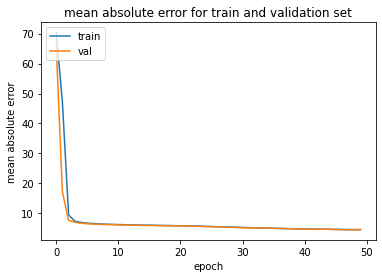

In [176]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('mean absolute error for train and validation set')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train','val'], loc = 'upper left')
plt.show()

I can see that my model is over fitting. 

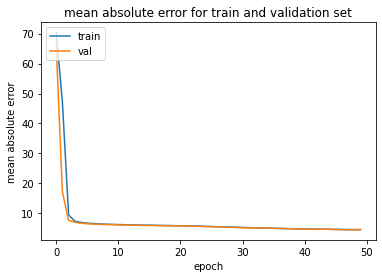

In [177]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('mean absolute error for train and validation set')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train','val'], loc = 'upper left')
plt.show()

I chose the activatioon function ReLU in the hidden layer. It is a commonly used activation function where if the input x is negative, then a value 0 is returned. 

MAE is more robust to outliers.

By analysis, we find that compared with ADAM, SGD is more locally unstable and is more likely to converge to the minima at the flat or asymmetric basins/valleys which often have better generalization performance over other type minima. So our results can explain the better generalization performance of SGD over ADAM. SO i didnt use adams

Source: https://machinelearningmastery.com/choose-an-activation-function-for-deep-learning/

In [182]:
# getting the metrics
from sklearn.metrics import mean_absolute_error

def metrics_for_mlp():
    y_pred = model.predict(final_df_x_test).ravel()
    mae = mean_absolute_error(y_test, y_pred)
    return mae

In [183]:
metrics_for_mlp()

58/58 [==============================] - 0s 5ms/step


5.1221044703164305

In [184]:
metric_list.append(round(6.78,2))

### Cat Boost

In [185]:
import optuna
from optuna.samplers import TPESampler
from catboost import CatBoostRegressor

In [186]:
def cb_objective(trial):
    learning_rate = trial.suggest_float('learning_rate',0.01,0.2)
    n_estimators = trial.suggest_int('n_estimators',100,500)
    depth = trial.suggest_int('depth', 1,10)
    l2_leaf_reg = trial.suggest_int('l2_leaf_reg', 3,15)
    
    cb = CatBoostRegressor(learning_rate = learning_rate, 
                            n_estimators = n_estimators,
                            depth = depth, 
                            l2_leaf_reg= l2_leaf_reg, 
                            loss_function = 'MAE')
    
    cb.fit(final_df_x_train, y_train)
    
    y_pred = cb.predict(final_df_x_val)
    
    return mean_squared_error(y_val, y_pred, squared=False)

study = optuna.create_study(direction = 'minimize')
study.optimize(cb_objective, n_trials=10)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)
    

[I 2022-12-01 17:03:00,602] A new study created in memory with name: no-name-a681b034-8cf6-4649-a58f-a1e1fb8e26b0


0:	learn: 14.1900259	total: 42.5ms	remaining: 6.75s
1:	learn: 13.2473122	total: 47.4ms	remaining: 3.75s
2:	learn: 12.4031112	total: 54.3ms	remaining: 2.84s
3:	learn: 11.6914204	total: 61.9ms	remaining: 2.42s
4:	learn: 10.9880079	total: 69.9ms	remaining: 2.17s
5:	learn: 10.4648931	total: 73.6ms	remaining: 1.89s
6:	learn: 9.9242303	total: 79.6ms	remaining: 1.74s
7:	learn: 9.5032393	total: 85.5ms	remaining: 1.63s
8:	learn: 9.0492185	total: 95.6ms	remaining: 1.6s
9:	learn: 8.6667233	total: 104ms	remaining: 1.57s
10:	learn: 8.2988771	total: 112ms	remaining: 1.51s
11:	learn: 7.9510965	total: 128ms	remaining: 1.58s
12:	learn: 7.6363702	total: 136ms	remaining: 1.53s
13:	learn: 7.3465999	total: 141ms	remaining: 1.47s
14:	learn: 7.0901958	total: 148ms	remaining: 1.43s
15:	learn: 6.8629183	total: 156ms	remaining: 1.4s
16:	learn: 6.6736961	total: 164ms	remaining: 1.38s
17:	learn: 6.4730013	total: 175ms	remaining: 1.38s
18:	learn: 6.3056635	total: 182ms	remaining: 1.35s
19:	learn: 6.1528907	total: 

[I 2022-12-01 17:03:03,372] Trial 0 finished with value: 4.626536956399611 and parameters: {'learning_rate': 0.0911125223193518, 'n_estimators': 160, 'depth': 7, 'l2_leaf_reg': 11}. Best is trial 0 with value: 4.626536956399611.


148:	learn: 3.1315364	total: 2.21s	remaining: 163ms
149:	learn: 3.1222364	total: 2.23s	remaining: 148ms
150:	learn: 3.1136785	total: 2.24s	remaining: 134ms
151:	learn: 3.1047515	total: 2.25s	remaining: 119ms
152:	learn: 3.1006633	total: 2.27s	remaining: 104ms
153:	learn: 3.0932262	total: 2.27s	remaining: 88.7ms
154:	learn: 3.0894106	total: 2.29s	remaining: 73.8ms
155:	learn: 3.0809414	total: 2.3s	remaining: 58.9ms
156:	learn: 3.0737346	total: 2.31s	remaining: 44.1ms
157:	learn: 3.0684849	total: 2.32s	remaining: 29.4ms
158:	learn: 3.0616974	total: 2.33s	remaining: 14.7ms
159:	learn: 3.0577854	total: 2.34s	remaining: 0us
0:	learn: 13.9200499	total: 64.5ms	remaining: 15.3s
1:	learn: 12.7958987	total: 116ms	remaining: 13.7s
2:	learn: 11.8241544	total: 140ms	remaining: 11s
3:	learn: 10.9262514	total: 159ms	remaining: 9.34s
4:	learn: 10.1504946	total: 193ms	remaining: 9.02s
5:	learn: 9.4826170	total: 224ms	remaining: 8.69s
6:	learn: 8.8631222	total: 284ms	remaining: 9.41s
7:	learn: 8.3118426

[I 2022-12-01 17:03:12,755] Trial 1 finished with value: 3.395231935363616 and parameters: {'learning_rate': 0.10777097550467445, 'n_estimators': 239, 'depth': 9, 'l2_leaf_reg': 5}. Best is trial 1 with value: 3.395231935363616.


0:	learn: 14.5557908	total: 9.69ms	remaining: 2.18s
1:	learn: 13.8627501	total: 16.5ms	remaining: 1.85s
2:	learn: 13.2627890	total: 18.7ms	remaining: 1.39s
3:	learn: 12.7901828	total: 21.3ms	remaining: 1.18s
4:	learn: 12.3596197	total: 25.5ms	remaining: 1.13s
5:	learn: 11.8189551	total: 33.3ms	remaining: 1.22s
6:	learn: 11.4150655	total: 36.1ms	remaining: 1.13s
7:	learn: 11.1520520	total: 38.9ms	remaining: 1.06s
8:	learn: 10.7960104	total: 42.6ms	remaining: 1.03s
9:	learn: 10.4606389	total: 47.1ms	remaining: 1.02s
10:	learn: 10.2870774	total: 52ms	remaining: 1.02s
11:	learn: 10.0184633	total: 55.9ms	remaining: 996ms
12:	learn: 9.7509319	total: 58.2ms	remaining: 953ms
13:	learn: 9.4874460	total: 65.9ms	remaining: 998ms
14:	learn: 9.2529184	total: 69.5ms	remaining: 977ms
15:	learn: 9.0808223	total: 73.3ms	remaining: 962ms
16:	learn: 8.8964499	total: 78.7ms	remaining: 967ms
17:	learn: 8.7385093	total: 81.1ms	remaining: 937ms
18:	learn: 8.6103826	total: 95.6ms	remaining: 1.04s
19:	learn: 8

[I 2022-12-01 17:03:14,104] Trial 2 finished with value: 6.5751223214999435 and parameters: {'learning_rate': 0.10142569080906078, 'n_estimators': 226, 'depth': 2, 'l2_leaf_reg': 4}. Best is trial 1 with value: 3.395231935363616.


224:	learn: 4.7789581	total: 980ms	remaining: 4.35ms
225:	learn: 4.7739139	total: 990ms	remaining: 0us
0:	learn: 13.8934006	total: 73.4ms	remaining: 27.4s
1:	learn: 12.7457796	total: 128ms	remaining: 23.8s
2:	learn: 11.7166596	total: 162ms	remaining: 20s
3:	learn: 10.8645246	total: 185ms	remaining: 17.1s
4:	learn: 10.1517117	total: 220ms	remaining: 16.2s
5:	learn: 9.4733204	total: 247ms	remaining: 15.2s
6:	learn: 8.8985850	total: 272ms	remaining: 14.2s
7:	learn: 8.3601600	total: 294ms	remaining: 13.4s
8:	learn: 7.8970413	total: 316ms	remaining: 12.8s
9:	learn: 7.4855818	total: 336ms	remaining: 12.2s
10:	learn: 7.1496145	total: 360ms	remaining: 11.9s
11:	learn: 6.8058259	total: 391ms	remaining: 11.8s
12:	learn: 6.5014679	total: 431ms	remaining: 12s
13:	learn: 6.2206089	total: 469ms	remaining: 12.1s
14:	learn: 5.9961734	total: 533ms	remaining: 12.8s
15:	learn: 5.7901346	total: 579ms	remaining: 13s
16:	learn: 5.5974822	total: 613ms	remaining: 12.9s
17:	learn: 5.4384042	total: 642ms	remain

[I 2022-12-01 17:03:22,377] Trial 3 finished with value: 3.300523348786554 and parameters: {'learning_rate': 0.1132688230658785, 'n_estimators': 374, 'depth': 8, 'l2_leaf_reg': 11}. Best is trial 3 with value: 3.300523348786554.


369:	learn: 1.6230981	total: 7.53s	remaining: 81.4ms
370:	learn: 1.6207962	total: 7.58s	remaining: 61.3ms
371:	learn: 1.6186573	total: 7.6s	remaining: 40.9ms
372:	learn: 1.6153034	total: 7.63s	remaining: 20.5ms
373:	learn: 1.6091414	total: 7.66s	remaining: 0us
0:	learn: 15.0639679	total: 12.7ms	remaining: 2.43s
1:	learn: 14.8887872	total: 20.7ms	remaining: 1.98s
2:	learn: 14.7256481	total: 40.9ms	remaining: 2.59s
3:	learn: 14.5544986	total: 64.5ms	remaining: 3.04s
4:	learn: 14.3873546	total: 81.9ms	remaining: 3.08s
5:	learn: 14.2215549	total: 89.8ms	remaining: 2.8s
6:	learn: 14.0648293	total: 102ms	remaining: 2.72s
7:	learn: 13.9096344	total: 119ms	remaining: 2.76s
8:	learn: 13.7579556	total: 134ms	remaining: 2.74s
9:	learn: 13.6094665	total: 151ms	remaining: 2.76s
10:	learn: 13.4639670	total: 158ms	remaining: 2.61s
11:	learn: 13.3173626	total: 165ms	remaining: 2.49s
12:	learn: 13.1731047	total: 171ms	remaining: 2.37s
13:	learn: 13.0370140	total: 182ms	remaining: 2.32s
14:	learn: 12.89

[I 2022-12-01 17:03:24,404] Trial 4 finished with value: 6.893030460162132 and parameters: {'learning_rate': 0.015901691116994493, 'n_estimators': 193, 'depth': 6, 'l2_leaf_reg': 6}. Best is trial 3 with value: 3.300523348786554.


183:	learn: 5.2446286	total: 1.7s	remaining: 83.4ms
184:	learn: 5.2316129	total: 1.71s	remaining: 74ms
185:	learn: 5.2210755	total: 1.72s	remaining: 64.6ms
186:	learn: 5.2093914	total: 1.73s	remaining: 55.4ms
187:	learn: 5.1980086	total: 1.73s	remaining: 46.1ms
188:	learn: 5.1877675	total: 1.74s	remaining: 36.8ms
189:	learn: 5.1764414	total: 1.74s	remaining: 27.5ms
190:	learn: 5.1669296	total: 1.75s	remaining: 18.3ms
191:	learn: 5.1568954	total: 1.75s	remaining: 9.14ms
192:	learn: 5.1482035	total: 1.76s	remaining: 0us
0:	learn: 14.3118228	total: 1.6ms	remaining: 663ms
1:	learn: 13.6345097	total: 2.92ms	remaining: 603ms
2:	learn: 12.9270559	total: 4.78ms	remaining: 656ms
3:	learn: 12.4691073	total: 6.97ms	remaining: 716ms
4:	learn: 12.0081233	total: 9.39ms	remaining: 770ms
5:	learn: 11.7393322	total: 11.3ms	remaining: 770ms
6:	learn: 11.5462982	total: 14.8ms	remaining: 863ms
7:	learn: 11.2537995	total: 16.8ms	remaining: 855ms
8:	learn: 11.0569631	total: 19ms	remaining: 855ms
9:	learn: 1

[I 2022-12-01 17:03:26,446] Trial 5 finished with value: 7.210306457519315 and parameters: {'learning_rate': 0.1629669876271952, 'n_estimators': 415, 'depth': 1, 'l2_leaf_reg': 3}. Best is trial 3 with value: 3.300523348786554.


0:	learn: 13.1992248	total: 77.5ms	remaining: 26.5s
1:	learn: 11.5984620	total: 122ms	remaining: 20.8s
2:	learn: 10.2427187	total: 152ms	remaining: 17.2s
3:	learn: 9.2018594	total: 184ms	remaining: 15.6s
4:	learn: 8.4283116	total: 213ms	remaining: 14.4s
5:	learn: 7.7467774	total: 254ms	remaining: 14.3s
6:	learn: 7.1543842	total: 301ms	remaining: 14.5s
7:	learn: 6.6829525	total: 340ms	remaining: 14.2s
8:	learn: 6.2452507	total: 378ms	remaining: 14s
9:	learn: 5.8915005	total: 433ms	remaining: 14.4s
10:	learn: 5.5902352	total: 481ms	remaining: 14.5s
11:	learn: 5.3493830	total: 524ms	remaining: 14.5s
12:	learn: 5.1069758	total: 564ms	remaining: 14.3s
13:	learn: 4.9218611	total: 605ms	remaining: 14.2s
14:	learn: 4.7412946	total: 643ms	remaining: 14.1s
15:	learn: 4.5943061	total: 677ms	remaining: 13.8s
16:	learn: 4.4657211	total: 695ms	remaining: 13.3s
17:	learn: 4.3606528	total: 737ms	remaining: 13.3s
18:	learn: 4.2516458	total: 771ms	remaining: 13.1s
19:	learn: 4.1438998	total: 799ms	remai

[I 2022-12-01 17:03:37,273] Trial 6 finished with value: 3.2303438896854466 and parameters: {'learning_rate': 0.1682008137664892, 'n_estimators': 343, 'depth': 9, 'l2_leaf_reg': 7}. Best is trial 6 with value: 3.2303438896854466.


342:	learn: 1.1557282	total: 10.3s	remaining: 0us
0:	learn: 14.5409403	total: 11.3ms	remaining: 5.13s
1:	learn: 13.8875335	total: 19.3ms	remaining: 4.38s
2:	learn: 13.3017782	total: 26.8ms	remaining: 4.03s
3:	learn: 12.7717153	total: 37.7ms	remaining: 4.25s
4:	learn: 12.2363105	total: 66ms	remaining: 5.94s
5:	learn: 11.7555156	total: 99.2ms	remaining: 7.42s
6:	learn: 11.2873236	total: 112ms	remaining: 7.17s
7:	learn: 10.8584766	total: 128ms	remaining: 7.14s
8:	learn: 10.4718910	total: 136ms	remaining: 6.73s
9:	learn: 10.1293838	total: 144ms	remaining: 6.42s
10:	learn: 9.7933465	total: 150ms	remaining: 6.06s
11:	learn: 9.4801616	total: 158ms	remaining: 5.82s
12:	learn: 9.1922292	total: 177ms	remaining: 6.01s
13:	learn: 8.9295691	total: 185ms	remaining: 5.83s
14:	learn: 8.6826384	total: 197ms	remaining: 5.78s
15:	learn: 8.4518435	total: 205ms	remaining: 5.64s
16:	learn: 8.2230706	total: 216ms	remaining: 5.57s
17:	learn: 7.9911836	total: 224ms	remaining: 5.44s
18:	learn: 7.7892403	total: 

[I 2022-12-01 17:03:42,371] Trial 7 finished with value: 3.7932494690709655 and parameters: {'learning_rate': 0.0603592458841748, 'n_estimators': 455, 'depth': 7, 'l2_leaf_reg': 5}. Best is trial 6 with value: 3.2303438896854466.


441:	learn: 2.3909933	total: 4.47s	remaining: 132ms
442:	learn: 2.3895386	total: 4.49s	remaining: 122ms
443:	learn: 2.3877128	total: 4.5s	remaining: 112ms
444:	learn: 2.3847555	total: 4.51s	remaining: 101ms
445:	learn: 2.3822635	total: 4.52s	remaining: 91.3ms
446:	learn: 2.3802200	total: 4.53s	remaining: 81.1ms
447:	learn: 2.3766129	total: 4.54s	remaining: 71ms
448:	learn: 2.3747082	total: 4.55s	remaining: 60.8ms
449:	learn: 2.3711789	total: 4.57s	remaining: 50.7ms
450:	learn: 2.3684067	total: 4.58s	remaining: 40.6ms
451:	learn: 2.3675787	total: 4.59s	remaining: 30.4ms
452:	learn: 2.3664883	total: 4.59s	remaining: 20.3ms
453:	learn: 2.3625409	total: 4.6s	remaining: 10.1ms
454:	learn: 2.3583860	total: 4.61s	remaining: 0us
0:	learn: 13.2877197	total: 47.6ms	remaining: 10.7s
1:	learn: 11.7502495	total: 115ms	remaining: 12.9s
2:	learn: 10.4531421	total: 191ms	remaining: 14.2s
3:	learn: 9.3632592	total: 230ms	remaining: 12.7s
4:	learn: 8.4959675	total: 276ms	remaining: 12.2s
5:	learn: 7.776

[I 2022-12-01 17:03:52,104] Trial 8 finished with value: 3.6951874879696223 and parameters: {'learning_rate': 0.15929176470183334, 'n_estimators': 225, 'depth': 10, 'l2_leaf_reg': 14}. Best is trial 6 with value: 3.2303438896854466.


0:	learn: 14.8328692	total: 11ms	remaining: 4.49s
1:	learn: 14.4602407	total: 21ms	remaining: 4.3s
2:	learn: 14.0717891	total: 33.6ms	remaining: 4.58s
3:	learn: 13.7152602	total: 51.2ms	remaining: 5.21s
4:	learn: 13.3801680	total: 57.3ms	remaining: 4.65s
5:	learn: 13.0449812	total: 77.1ms	remaining: 5.2s
6:	learn: 12.7506416	total: 86.5ms	remaining: 4.99s
7:	learn: 12.4535771	total: 94.7ms	remaining: 4.77s
8:	learn: 12.1760686	total: 103ms	remaining: 4.59s
9:	learn: 11.9643607	total: 114ms	remaining: 4.57s
10:	learn: 11.6880074	total: 132ms	remaining: 4.79s
11:	learn: 11.4507777	total: 137ms	remaining: 4.54s
12:	learn: 11.2072932	total: 142ms	remaining: 4.36s
13:	learn: 10.9786229	total: 150ms	remaining: 4.24s
14:	learn: 10.7569333	total: 156ms	remaining: 4.11s
15:	learn: 10.5524272	total: 161ms	remaining: 3.96s
16:	learn: 10.3808231	total: 168ms	remaining: 3.89s
17:	learn: 10.1847724	total: 175ms	remaining: 3.83s
18:	learn: 9.9901469	total: 188ms	remaining: 3.88s
19:	learn: 9.8226850	

[I 2022-12-01 17:03:55,213] Trial 9 finished with value: 5.240240087862795 and parameters: {'learning_rate': 0.03805098377662515, 'n_estimators': 411, 'depth': 5, 'l2_leaf_reg': 5}. Best is trial 6 with value: 3.2303438896854466.


397:	learn: 3.6258281	total: 2.58s	remaining: 84.4ms
398:	learn: 3.6232352	total: 2.59s	remaining: 78ms
399:	learn: 3.6209195	total: 2.6s	remaining: 71.6ms
400:	learn: 3.6185136	total: 2.61s	remaining: 65.1ms
401:	learn: 3.6152070	total: 2.62s	remaining: 58.7ms
402:	learn: 3.6118137	total: 2.63s	remaining: 52.1ms
403:	learn: 3.6093836	total: 2.63s	remaining: 45.6ms
404:	learn: 3.6067154	total: 2.64s	remaining: 39.1ms
405:	learn: 3.6045760	total: 2.65s	remaining: 32.6ms
406:	learn: 3.6029584	total: 2.65s	remaining: 26.1ms
407:	learn: 3.6016741	total: 2.66s	remaining: 19.5ms
408:	learn: 3.6000019	total: 2.66s	remaining: 13ms
409:	learn: 3.5985807	total: 2.67s	remaining: 6.51ms
410:	learn: 3.5950943	total: 2.68s	remaining: 0us
Best Score: 3.2303438896854466
Best trial: {'learning_rate': 0.1682008137664892, 'n_estimators': 343, 'depth': 9, 'l2_leaf_reg': 7}


In [187]:
cat = CatBoostRegressor(learning_rate= 0.1596297433219325, n_estimators= 402, depth= 6, l2_leaf_reg= 8)
cat.fit(final_df_x_train, y_train)

y_pred = cat.predict(final_df_x_test)
y_val_pred = cat.predict(final_df_x_val)


mae_train = (np.sqrt(mean_squared_error(y_train,y_train)))
mae_val = (np.sqrt(mean_squared_error(y_val,y_val_pred)))
mae = (np.sqrt(mean_squared_error(y_test,y_pred)))
r2 = r2_score(y_test,y_pred)

print("Testing Performance")
print('MAE train: {:.2f}'.format(mae_train))
print('MAE val : {:.2f}'.format(mae_val))
print('MAE test: {:.2f}'.format(mae))
print('r2:{:.2f}'.format(r2))

0:	learn: 18.1412559	total: 16.5ms	remaining: 6.63s
1:	learn: 16.3990200	total: 25.3ms	remaining: 5.07s
2:	learn: 15.0165423	total: 28.9ms	remaining: 3.85s
3:	learn: 13.8581408	total: 35.7ms	remaining: 3.55s
4:	learn: 12.8106009	total: 39.6ms	remaining: 3.14s
5:	learn: 11.9820239	total: 43.8ms	remaining: 2.89s
6:	learn: 11.1942151	total: 56.2ms	remaining: 3.17s
7:	learn: 10.5166134	total: 70.2ms	remaining: 3.46s
8:	learn: 9.9210317	total: 80.3ms	remaining: 3.51s
9:	learn: 9.5427220	total: 85.8ms	remaining: 3.36s
10:	learn: 9.1340319	total: 92.2ms	remaining: 3.28s
11:	learn: 8.8089711	total: 96.9ms	remaining: 3.15s
12:	learn: 8.4508629	total: 102ms	remaining: 3.06s
13:	learn: 8.1812703	total: 111ms	remaining: 3.09s
14:	learn: 7.9474008	total: 120ms	remaining: 3.09s
15:	learn: 7.7161086	total: 130ms	remaining: 3.13s
16:	learn: 7.5299823	total: 136ms	remaining: 3.09s
17:	learn: 7.3872007	total: 144ms	remaining: 3.08s
18:	learn: 7.2591370	total: 148ms	remaining: 2.98s
19:	learn: 7.1202061	

In [188]:
metric_list.append(mae)

This is incredible. The MAE score is so low. And it shows training set MAE is higher than MAE test. 

In [189]:
result_df = pd.DataFrame(metric_list, index = ['Lasso Regression','Decision Tree Regressor','Multilayer Perceptron','Catboost'], columns = ['Mean Absolute Error'])
result_df

,Mean Absolute Error
Lasso Regression,7.739989
Decision Tree Regressor,6.013526
Multilayer Perceptron,6.780000
Catboost,4.443611


## SHAP (SHapley Additive exPlanations)

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model. It connects optimal credit allocation with local explanations using the classic Shapley values from game theory and their related extensions

Resource: https://github.com/slundberg/shap

0:	learn: 18.1412559	total: 6.47ms	remaining: 2.59s
1:	learn: 16.3990200	total: 24.9ms	remaining: 4.97s
2:	learn: 15.0165423	total: 35.8ms	remaining: 4.76s
3:	learn: 13.8581408	total: 44.2ms	remaining: 4.4s
4:	learn: 12.8106009	total: 54.3ms	remaining: 4.31s
5:	learn: 11.9820239	total: 76.7ms	remaining: 5.06s
6:	learn: 11.1942151	total: 98.3ms	remaining: 5.54s
7:	learn: 10.5166134	total: 141ms	remaining: 6.93s
8:	learn: 9.9210317	total: 164ms	remaining: 7.16s
9:	learn: 9.5427220	total: 176ms	remaining: 6.89s
10:	learn: 9.1340319	total: 190ms	remaining: 6.77s
11:	learn: 8.8089711	total: 204ms	remaining: 6.63s
12:	learn: 8.4508629	total: 222ms	remaining: 6.64s
13:	learn: 8.1812703	total: 235ms	remaining: 6.51s
14:	learn: 7.9474008	total: 242ms	remaining: 6.24s
15:	learn: 7.7161086	total: 249ms	remaining: 6s
16:	learn: 7.5299823	total: 260ms	remaining: 5.88s
17:	learn: 7.3872007	total: 270ms	remaining: 5.76s
18:	learn: 7.2591370	total: 280ms	remaining: 5.65s
19:	learn: 7.1202061	total: 29

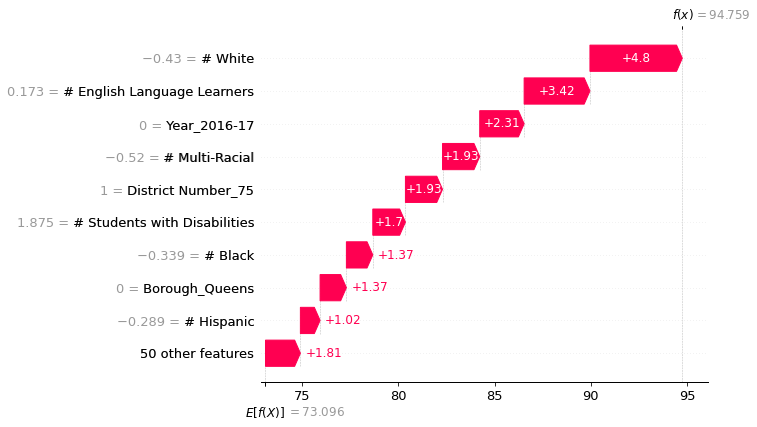

In [190]:
import shap

cat = CatBoostRegressor(learning_rate= 0.1596297433219325, n_estimators= 402, depth= 6, l2_leaf_reg= 8)
cat.fit(final_df_x_train, y_train)

explainer = shap.Explainer(cat)
shap_values = explainer(final_df_x_train)

shap.plots.waterfall(shap_values[0])

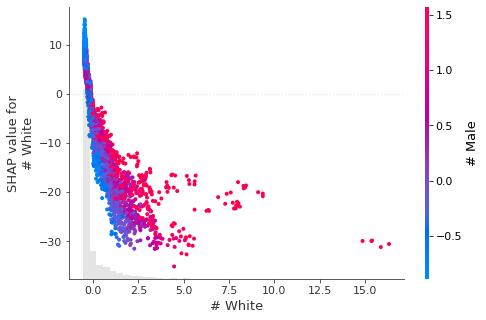

<Figure size 432x288 with 0 Axes>

In [191]:
shap.plots.scatter(shap_values[:,'# White'], color=shap_values)
plt.savefig('/users/taehyun/Dropbox/Springboard/NYC_Capstone_project/NewYorkCity_Education/image/SHAP_bar.jpeg',bbox_inches='tight')

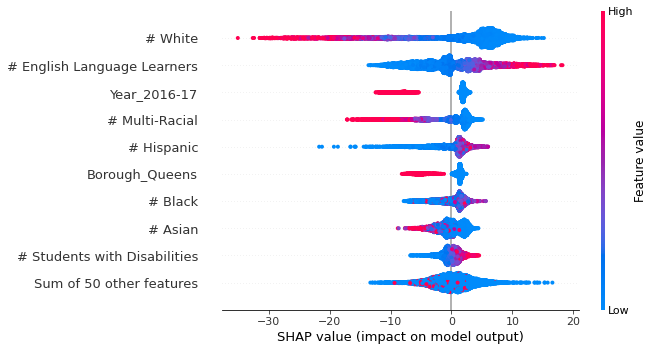

In [192]:
shap.plots.beeswarm(shap_values)

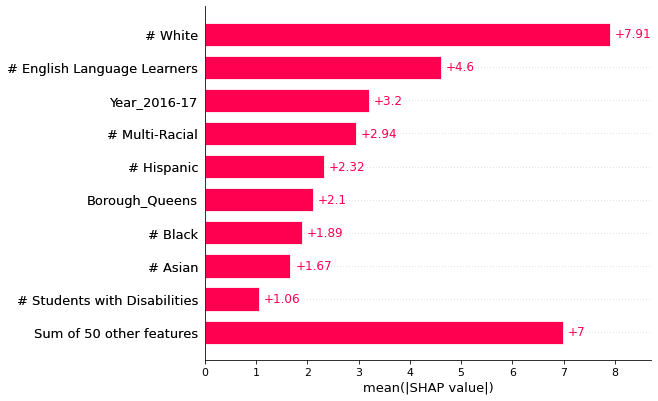

In [193]:
shap.plots.bar(shap_values)

### Choosing the right model.

CatBoost is the best model with MAE score of 4.443611.

• Validation set MAE score: 3.55
• Test set MAE score: 4.44

With this highly accuracte model, we can predict the economic index by the corresponding values borough,grade,race in New York City. The mae would be 4.86 which is highly accurate. 

## Making adjustments of the results.

In [194]:
df_bronx = nyc_pandas[nyc_pandas['Borough'] == 'Bronx'].mean().reset_index().rename(columns = {'index':'index',0:'val'})

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


In [195]:
Staten_Island_bronx = nyc_pandas[nyc_pandas['Borough'] == 'Staten Island'].mean().reset_index().rename(columns = {'index':'index',0:'val'})

Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


FixedFormatter should only be used together with FixedLocator


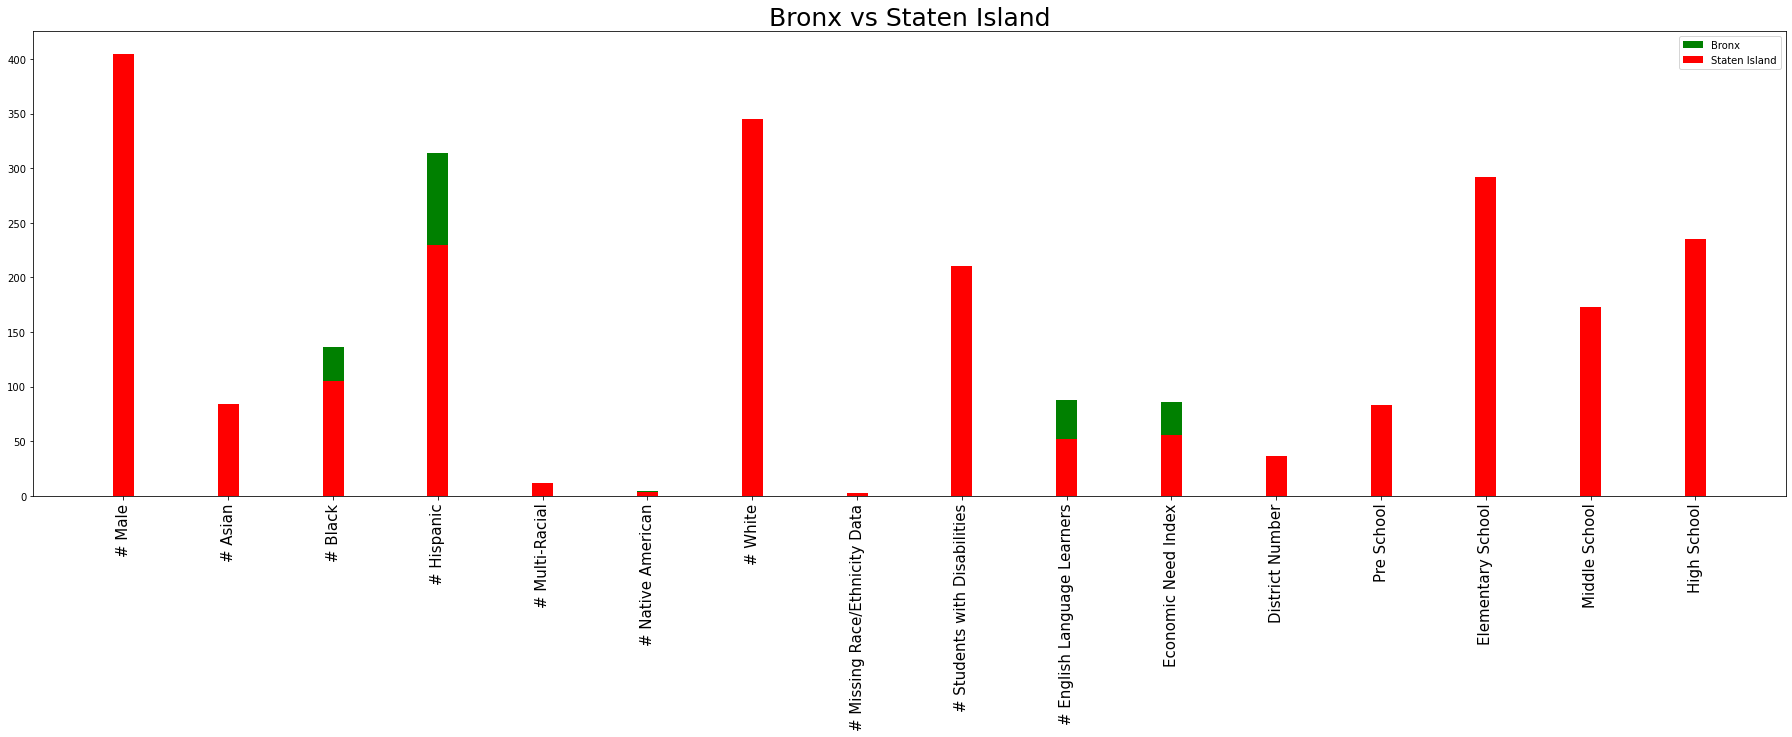

In [196]:
plt.figure(figsize=(25,10))
ax = plt.subplot(111)
width = 0.27
len_xaxis = len(Staten_Island_bronx['index'])

rects = ax.bar(df_bronx['index'], df_bronx['val'], width = 0.2, color = 'g')
rects2 = ax.bar(Staten_Island_bronx['index'], Staten_Island_bronx['val'], width = 0.2, color = 'r')

ax.legend(['Bronx','Staten Island'])
ax.set_xticklabels((Staten_Island_bronx['index']), rotation = 'vertical', fontsize = 15)

plt.tight_layout()

plt.title('Bronx vs Staten Island', fontsize= 25)
plt.savefig('/users/taehyun/Dropbox/Springboard/NYC_Capstone_project/NewYorkCity_Education/image/Bronx_Staten.jpeg',bbox_inches='tight')


According to the graph, Bronx has 4 features that are different with State Island. Staten Island has the last economic Need Index which is 55 and the Bronx has most economic Nddex Index with 85. Therefore, we can make several assumtpions through this graph. 

If we reduce the number of Hispanic, Black, and English Language Learner in Bronx, would the economic need index decrease as well? 

To experiment this, we will use the x_test data and modify the amount of hispanic people, black people, and englush language learners in Bronx and see how theoretically decreaseing these features will influence the economic need index 

In [197]:
print("Mean value of white people in bronx:",final_df_x_test[final_df_x_test['Borough_Bronx']==1.0]['# White'].mean())

Mean value of white people in bronx: -0.3478678077578059


In [198]:
print("Mean value of economic need index in bronx:", cat.predict(final_df_x_test[final_df_x_test['Borough_Bronx']==1.0]).mean())

Mean value of economic need index in bronx: 84.09009758268968


# Case 1. If we increase the population of white:

In [199]:
def adjust(data):
    return data + 0.3

bronx_df = final_df_x_test[final_df_x_test['Borough_Bronx']==1.0]
bronx_df.shape

(436, 59)

In [200]:
bronx_df['# White'] = bronx_df['# White'].apply(adjust)

bronx_df.shape


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(436, 59)

In [201]:
pd.DataFrame(sc.inverse_transform(bronx_df.loc[:,'# Male':]), columns = bronx_df.loc[:,'# Male':].columns)

,# Male,# Asian,# Black,# Hispanic,# Multi-Racial,# Native American,# White,# Missing Race/Ethnicity Data,# Students with Disabilities,# English Language Learners,Pre School,Elementary School,Middle School,High School
0,273.287526,10.299849,166.102553,347.304321,1.985927,3.511253,61.499366,0.246055,120.986870,60.319566,141.717179,398.783754,-7.611877,12.839328
1,197.420126,45.612206,22.079029,260.299711,-0.036684,5.152032,63.853353,0.246055,31.125845,261.533138,-3.277326,-1.530377,-7.611877,368.106274
2,150.259310,3.433558,63.092351,214.238447,1.985927,1.050084,49.729431,0.246055,69.316781,47.682965,86.826402,193.108574,-7.611877,12.839328
3,266.110881,24.032432,190.901305,318.643979,0.974621,5.972421,61.499366,3.118238,54.714365,84.620722,69.219926,374.704709,96.922428,12.839328
4,193.319186,2.452659,102.198076,224.474284,-0.036684,1.050084,48.552437,0.246055,94.028563,29.214086,-3.277326,-1.530377,301.282283,12.839328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,79.518086,13.242545,25.894222,103.691414,0.974621,1.870474,73.269301,0.246055,21.016480,46.710918,61.970201,99.802273,-7.611877,12.839328
432,257.908999,19.127938,126.043030,333.997733,-0.036684,3.511253,55.614398,0.246055,137.835813,71.984121,-3.277326,-1.530377,450.078860,12.839328
433,217.924829,20.108837,110.782259,267.464797,-0.036684,9.253979,57.968385,0.246055,127.726447,92.397092,85.790727,328.553205,-7.611877,12.839328
434,407.593329,12.261647,187.086113,515.172038,-0.036684,20.739432,65.030346,0.246055,164.794120,202.238317,166.573379,585.396357,-7.611877,12.839328


In [202]:
print("Mean value of white people in bronx:",bronx_df[bronx_df['Borough_Bronx']==1.0]['# White'].mean())

Mean value of white people in bronx: -0.047867807757806496


In [203]:
print("mean value of economic need index after adjusting the scale for white people:", cat.predict(bronx_df[bronx_df['Borough_Bronx']==1.0]).mean())

mean value of economic need index after adjusting the scale for white people: 77.16624326511734


In [204]:
0.8409009758268968 -  0.7716624326511734

0.06923854317572342

decreased economic need index by 0.069

When we increase the amount of white people by scale of 0.3 in the given condition mean = 0 and std = 1, Economic Need Index will decrease meaning higher graduation rate of that school and the average poverty rate will decrease.

# Case 2: Reduce Black and Hispanic people in Bronx.

In [205]:
def reduce(data, x):
    return data - x

bronx_df = final_df_x_test[final_df_x_test['Borough_Bronx']==1.0]
print("Average black people before reducing number of black people", bronx_df['# Black'].mean())

Average black people before reducing number of black people -0.10542368093441652


In [206]:
dic = {}

for i in np.arange(0.1,2.0,0.05):
    bronx_df['# Black'] = bronx_df['# Black'].apply(reduce, x = i)
    dic[i] = cat.predict(bronx_df[bronx_df['Borough_Bronx']==1.0]).mean()
    
dic


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{0.1: 83.99083172497511,
 0.15000000000000002: 83.71423719068633,
 0.20000000000000004: 83.38455397124729,
 0.25000000000000006: 83.04173371626376,
 0.30000000000000004: 82.84447203438963,
 0.3500000000000001: 82.72511324634995,
 0.40000000000000013: 82.67840790953001,
 0.45000000000000007: 82.6439651861716,
 0.5000000000000001: 82.63190663277254,
 0.5500000000000002: 82.62520258070646,
 0.6000000000000002: 82.59797810133385,
 0.6500000000000001: 82.59472859654147,
 0.7000000000000002: 82.59625457400405,
 0.7500000000000002: 82.59723628524307,
 0.8000000000000002: 82.59611707986514,
 0.8500000000000002: 82.59611707986514,
 0.9000000000000002: 82.59611707986514,
 0.9500000000000003: 82.59611707986514,
 1.0000000000000004: 82.59611707986514,
 1.0500000000000003: 82.59611707986514,
 1.1000000000000005: 82.59611707986514,
 1.1500000000000004: 82.59611707986514,
 1.2000000000000004: 82.59611707986514,
 1.2500000000000004: 82.59611707986514,
 1.3000000000000005: 82.59611707986514,
 1.3500000

no matter how much we reduce the number of black people, the economic need index stays the same

In [207]:
bronx_df['# Black'] = bronx_df['# Black'].apply(reduce, x = 0.4)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [208]:
print("Average black people after reducing number of black people", bronx_df['# Black'].mean())

Average black people after reducing number of black people -39.45542368093444


In [209]:
print("mean value of economic need index after cutting off 0.3 black people:", cat.predict(bronx_df[bronx_df['Borough_Bronx']==1.0]).mean())


mean value of economic need index after cutting off 0.3 black people: 82.59611707986514


In [210]:
0.8409009758268968 -  0.8259611707986514

0.014939805028245434

Decreased the econominc need index by 0.015 by decreasing the number of black people

In [211]:
def reduce(data, x):
    return data - x

bronx_df = final_df_x_test[final_df_x_test['Borough_Bronx']==1.0]
print("Average Hispanic people before reducing number of Hispanic people", bronx_df['# Hispanic'].mean())
print("mean value of economic need index after adjusting the scale for white people:", cat.predict(bronx_df[bronx_df['Borough_Bronx']==1.0]).mean())

Average Hispanic people before reducing number of Hispanic people 0.37157377881720105
mean value of economic need index after adjusting the scale for white people: 84.09009758268968


In [212]:
dic = {}

for i in np.arange(0.1,2.0,0.05):
    bronx_df['# Hispanic'] = bronx_df['# Hispanic'].apply(reduce, x = i)
    dic[i] = cat.predict(bronx_df[bronx_df['Borough_Bronx']==1.0]).mean()
    
dic


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{0.1: 83.97881802829602,
 0.15000000000000002: 83.74514104543354,
 0.20000000000000004: 83.09579180735318,
 0.25000000000000006: 81.90435766286845,
 0.30000000000000004: 80.18494293927047,
 0.3500000000000001: 78.26537993132507,
 0.40000000000000013: 76.80184395997793,
 0.45000000000000007: 75.83568399597328,
 0.5000000000000001: 75.25968284777994,
 0.5500000000000002: 74.89757243926496,
 0.6000000000000002: 74.67255491765647,
 0.6500000000000001: 74.61998907921837,
 0.7000000000000002: 74.61391236665125,
 0.7500000000000002: 74.59173990577766,
 0.8000000000000002: 74.52169434140932,
 0.8500000000000002: 74.52169434140932,
 0.9000000000000002: 74.52169434140932,
 0.9500000000000003: 74.52169434140932,
 1.0000000000000004: 74.52169434140932,
 1.0500000000000003: 74.52169434140932,
 1.1000000000000005: 74.52169434140932,
 1.1500000000000004: 74.52169434140932,
 1.2000000000000004: 74.52169434140932,
 1.2500000000000004: 74.52169434140932,
 1.3000000000000005: 74.52169434140932,
 1.350000

In [213]:
0.84-0.74

0.09999999999999998

The more value that is subtracted by 0.5, the more ineffective it is. Therefore we should set the x as 0.5 and will return a result with a decrease of 0.1 economic need index

# Case 3: Reduce English Learners in Bronx

Now let's see if the amount of english learners in Bronx actually influences the economic need index

In [214]:
bronx_df = final_df_x_test[final_df_x_test['Borough_Bronx']==1.0]
print("Average black people before reducing number of black people", bronx_df['# English Language Learners'].mean())
print("Average Economic Need Index of people in Bronx:", cat.predict(bronx_df).mean())


Average black people before reducing number of black people 0.0681912997351013
Average Economic Need Index of people in Bronx: 84.09009758268968


In [215]:
def reduce_english(data, x):
    return data - x

dic = {}

for i in np.arange(0.1,1.0,0.01):
    bronx_df['# English Language Learners'] = bronx_df['# English Language Learners'].apply(reduce_english, x = i)
    dic[i] = cat.predict(bronx_df[bronx_df['Borough_Bronx']==1.0]).mean()
    
dic


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{0.1: 82.97542594357314,
 0.11: 81.70571984113415,
 0.12: 80.44098465164029,
 0.13: 79.23182084470672,
 0.13999999999999999: 78.33544667883449,
 0.14999999999999997: 77.51351272422978,
 0.15999999999999998: 76.95835839175338,
 0.16999999999999998: 76.62256440596948,
 0.17999999999999997: 76.28817060642399,
 0.18999999999999995: 76.07167961569922,
 0.19999999999999996: 75.88200926551406,
 0.20999999999999996: 75.62631466974342,
 0.21999999999999995: 75.38088116994003,
 0.22999999999999995: 75.10808946527351,
 0.23999999999999994: 75.00167251517813,
 0.24999999999999992: 74.93236725737496,
 0.2599999999999999: 74.8758228965818,
 0.2699999999999999: 74.82988319676546,
 0.2799999999999999: 74.7813077552297,
 0.2899999999999999: 74.77709563654014,
 0.29999999999999993: 74.76433997646986,
 0.30999999999999994: 74.74938779339917,
 0.3199999999999999: 74.72913327562816,
 0.32999999999999985: 74.71839192290722,
 0.33999999999999986: 74.71839192290722,
 0.34999999999999987: 74.71839192290722,
 0

From decreasing the economic need index from 84 to 76 by decreasing the scale of # English Learners by 0.15, the economic need index decreased by 0.08.

The main goal of this project was to build a predictive regression model that can predict the economc need index and make conclusions to inform the results to NYC.

### 3 possible solutions which can help decrease the economic need index. 

1. Increase the number of white people

• By increasing the white population by 0.1 in the given condition where mean = 0 and std = 1, there was a decrease in economic need index by 0.069

2. Decrease the number of black and hispanic people

• By decreasing the black population by 0.3 in the given condition where mean = 0 and std = 1, there was a decrease in economic need index by 0.015

• By decreasing the hispanic population by 0.15 in the given condition where mean = 0 and std = 1, there was a decrease in economic need index by 0.1

3. Decrease the number of english learners

• By decreasing the english learners by 0.2 in the given condition where mean = 0 and std = 1, there was a decrease in economic need index by 0.08